<a href="https://colab.research.google.com/github/carolmnb/CFD-PUCRJ/blob/master/PINN_deep_dive_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf


In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# tf.compat.v1.disable_eager_execution()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# PINN Solution applied to 2D acoustic equation

### Dados de treinamento             

Como a solução exata da EDP 2d da acústica é difícil de ser obtida, optou-se por utilizar MDF. Os dados gerados são: **coordenadas x-y, tempo e pressão**, que serão os parâmetros de entrada para treinamento do modelo.

Formulação do problema:
\
\begin{equation}
\small
\nabla^2 p = \frac{1}{c^2} \frac{\partial^2{p}}{\partial t^2}+S
\end{equation}

\begin{equation}
\small
S = \exp\left(-\frac{(\Delta x- x_0)^{2} + (\Delta y - y_0)^{2}}{2 \sigma^{2}}\right) \cdot \sin(\omega \cdot n \cdot \Delta x)
\end{equation}


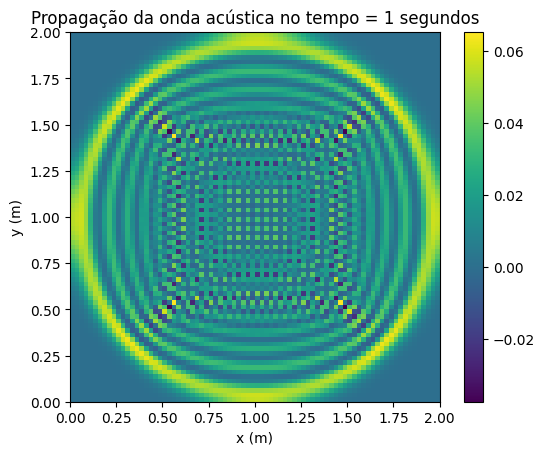

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
c = 1  # Velocidade do som
Lx = Ly = 2  # Comprimento da malha em x e y (m) Lx = Ly = 10
Nx = Ny = 80  # Número de pontos na malha Nx = Ny = 100
dx = dy = Lx / Nx  # Espaçamento da malha
# dt = 0.5 * 1/(c * np.sqrt(1/dx**2 + 1/dy**2))  # Passo de tempo (s)
dt = 0.01 # dt = 0.001
T_total = 5  # Tempo total de simulação (s)
T_target = 1  # Tempo desejado para a visualização (s)
Nt_total = int(T_total / dt)  # Número total de passos de tempo para alcançar T_total
Nt_target = int(T_target / dt)  # Número total de passos de tempo para alcançar T_target

# Inicialização dos campos de pressão
p = np.zeros((Nx, Ny))  # Pressão no tempo atual
p_prev = np.zeros((Nx, Ny))  # Pressão no tempo anterior
p_next = np.zeros((Nx, Ny))  # Pressão no próximo tempo

# Fonte de pulso acústico
source_amplitude = 1
source_x = source_y = Nx // 2
p[source_x, source_y] = source_amplitude

# Função para atualizar os campos de pressão (vetorizada)
def update_pressure(p, p_prev, c, dx, dy, dt):
    laplacian = (np.roll(p, -1, axis=0) - 2*p + np.roll(p, 1, axis=0)) / dx**2 + \
                (np.roll(p, -1, axis=1) - 2*p + np.roll(p, 1, axis=1)) / dy**2
    p_next = 2*p - p_prev + c**2 * dt**2 * laplacian
    return p_next

# Simulação até o tempo desejado
for t in range(1, Nt_total + 1):
    p_next = update_pressure(p, p_prev, c, dx, dy, dt)
    p_prev, p = p, p_next  # Atualiza os campos de pressão

    # Captura o estado da pressão em T_target = 4 segundos
    if t == Nt_target:
        p_at_target = p.copy()

# Visualização do estado no tempo T_target
plt.imshow(p_at_target, cmap='viridis', extent=[0, Lx, 0, Ly])
plt.colorbar()
plt.title(f'Propagação da onda acústica no tempo = {T_target} segundos')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


### Gerando os dados de treinamento

In [ ]:
def generate_PINN_data(c=1, Lx=10, Ly=10, Nx=100, Ny=100, T_total=5, dt=None):
    # Parâmetros da simulação
    dx = dy = Lx / Nx  # Espaçamento da malha
    dt = 0.01
    # if dt is None:
    #     dt = 0.5 * 1/(c * np.sqrt(1/dx**2 + 1/dy**2))  # Passo de tempo (s)
    Nt_total = int(T_total / dt)  # Número total de passos de tempo para alcançar T_total

    # Inicialização dos campos de pressão
    p = np.zeros((Nx, Ny))  # Pressão no tempo atual
    p_prev = np.zeros((Nx, Ny))  # Pressão no tempo anterior
    p_next = np.zeros((Nx, Ny))  # Pressão no próximo tempo

    # Fonte de pulso acústico
    source_amplitude = 1
    source_x = source_y = Nx // 2
    p[source_x, source_y] = source_amplitude

    # Função para atualizar os campos de pressão (vetorizada)
    def update_pressure(p, p_prev, c, dx, dy, dt):
        laplacian = (np.roll(p, -1, axis=0) - 2*p + np.roll(p, 1, axis=0)) / dx**2 + \
                    (np.roll(p, -1, axis=1) - 2*p + np.roll(p, 1, axis=1)) / dy**2
        p_next = 2*p - p_prev + c**2 * dt**2 * laplacian
        return p_next

    # Preparar dados para o PINN
    X, Y = np.meshgrid(np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)) # cria uma seq. linear de ptos igual espaçados
    T = np.linspace(0, T_total, Nt_total) # cria uma sequencia linear de tempo igualmente espaçada
    PINN_data = []

    # Simulação e coleta de dados
    for t_idx, t in enumerate(T):
        p_next = update_pressure(p, p_prev, c, dx, dy, dt)
        p_prev, p = p, p_next  # Atualiza os campos de pressão

        PINN_data.append((X.flatten(), Y.flatten(), np.full(X.size, t), p.flatten()))

    # Converter lista de dados em arrays do NumPy
    PINN_data = np.array(PINN_data, dtype=object).T
    X_data, Y_data, T_data, P_data = np.concatenate(PINN_data[0]), np.concatenate(PINN_data[1]), np.concatenate(PINN_data[2]), np.concatenate(PINN_data[3])

    return X_data, Y_data, T_data, P_data



### Arquitetura da rede neural

Essa etapa é definida a arquitetura da rede. A classe `RedeNeural` utiliza a clase tf.keras.Model do TensorFlow para construir um modelo de rede neural de alto nível.

* `self.camada_oculta`: primeira camada oculta. Possui 100 neurônios e utiliza a função de ativação `tanh`. O `glorot_uniform` é um inicializador de pesos, que gera valores aleatórios de acordo com uma distribuição normal.
* `self.camada_saida`: camada de saída da rede. O número 1 indica que haverá apenas uma saída, que no caso trata-se da pressão calculada.




In [ ]:
class RedeNeural(tf.keras.Model):
    def __init__(self):
        super(RedeNeural, self).__init__()
        self.camada_oculta1 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer='glorot_uniform')
        self.camada_oculta2 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer='glorot_uniform')
        # self.camada_oculta3 = tf.keras.layers.Dense(50, activation='tanh', kernel_initializer='glorot_uniform')
        self.camada_saida = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.camada_oculta1(inputs)
        x = self.camada_oculta2(x)
        # x = self.camada_oculta3(x)
        return self.camada_saida(x)

###Cálculo da perda
Nessa etapa será calculada a perda física utilizando PINN a partir dos dados de treinamento. Lembrando que a perda física é fornecida pela diferença entre os dois termos da equação, cujo resultado necessita ser próximo de zero para garantir a precisão do modelo.


In [ ]:
def perda(model, X_data, Y_data, T_data, P_data, c, source_x, source_y, source_t, amplitude):
    # Convertendo dados para tensores do TensorFlow
    X = tf.convert_to_tensor(X_data, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y_data, dtype=tf.float32)
    T = tf.convert_to_tensor(T_data, dtype=tf.float32)
    P_real = tf.convert_to_tensor(P_data, dtype=tf.float32)

    # Usando o GradientTape do TensorFlow para calcular as derivadas
    with tf.GradientTape(persistent=True) as tape:
        # Observando as variáveis de entrada para diferenciação automática
        tape.watch(X)
        tape.watch(Y)
        tape.watch(T)

        # Combinando as variáveis de entrada em um único tensor
        inputs = tf.stack([X, Y, T], axis=1)

        # Passando os dados de entrada pela rede neural para obter a pressão prevista
        P_pred = model(inputs)

        # Calculando as derivadas de primeira ordem da pressão em relação ao tempo
        dPdT = tape.gradient(P_pred, T)

        # Calculando as derivadas de segunda ordem da pressão em relação ao tempo
        d2PdT2 = tape.gradient(dPdT, T)

        # Calculando as derivadas de segunda ordem da pressão em relação a x e y
        d2Pdx2 = tape.gradient(tape.gradient(P_pred, X), X)
        d2Pdy2 = tape.gradient(tape.gradient(P_pred, Y), Y)

    # Calculando a equação acústica do lado direito (Laplaciano da pressão)
    laplacian_p = d2Pdx2 + d2Pdy2

    # Definindo o termo fonte como uma função delta de Dirac no tempo e no espaço
    source_term = amplitude * tf.exp(-((X - source_x)**2 + (Y - source_y)**2) / (0.1**2)) * tf.cast(tf.equal(T, source_t), tf.float32)

    # Calculando a discrepância entre o lado esquerdo e o lado direito da equação acústica, incluindo o termo fonte
    f_residual = d2PdT2 - c**2 * laplacian_p - source_term

    # Calculando a perda de dados (diferença entre a pressão prevista e a real)
    loss_dados = tf.reduce_mean(tf.square(P_pred - P_real))

    # Calculando a perda física como a média dos quadrados das discrepâncias
    loss_fisica = tf.reduce_mean(tf.square(f_residual))

    # Combinando a perda física e a perda de dados
    loss_total = loss_fisica + loss_dados

    # del tape
    del tape
    return loss_total

# Inicialização do modelo e otimizador
model = RedeNeural()
otimizador = tf.optimizers.Adam(learning_rate=0.5)

# Parâmetros da simulação
Lx = 2  # 10.0  # Comprimento no eixo x
Ly = 2  #10.0  # Comprimento no eixo y
Nx = 80 #100   # Número de pontos de grade no eixo x
Ny = 80 #100   # Número de pontos de grade no eixo y
T_total = 5.0    # Tempo total
c = 1.0    # Velocidade do som
source_x = Nx // 2
source_y = Ny // 2
source_t = 0.0
amplitude = 1.0  # Amplitude da fonte

X_data, Y_data, T_data, P_data = generate_PINN_data(c=c, Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, T_total=T_total)
# Parametros do modelo
tamanho_lote = 500
numero_epocas = 1000

# Dividindo os dados em lotes
# num_batches = len(X_data) // tamanho_lote
for epoca in range(numero_epocas):

    if len(X_data) > 0:
        num_batches = max(len(X_data) // tamanho_lote, 1)  # Garante pelo menos um lote
        loss_value_epoch = 0

        for i in range(num_batches):
          start_idx = i * tamanho_lote
          end_idx = start_idx + tamanho_lote
          X_batch, Y_batch, T_batch, P_batch = X_data[start_idx:end_idx], Y_data[start_idx:end_idx], T_data[start_idx:end_idx], P_data[start_idx:end_idx]

          with tf.GradientTape() as tape:
              inputs = tf.convert_to_tensor(np.stack([X_batch, Y_batch, T_batch], axis=1), dtype=tf.float32)
              loss_value = perda(model, X_batch, Y_batch, T_batch, P_batch, c, source_x, source_y, source_t, amplitude)

          gradientes = tape.gradient(loss_value, model.trainable_variables)
          otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

          # Acumule a perda de cada lote para obter a perda total da época
          loss_value_epoch += loss_value.numpy()

      # Calcule a perda média da época
        loss_value_epoch /= num_batches

      # Imprimindo a perda a cada 100 épocas
        if (epoca + 1) % 100 == 0:
          print(f'Época {epoca + 1}, Perda: {loss_value_epoch}')


Época 100, Perda: 27.075896382331848
Época 200, Perda: 22.01373541355133
Época 300, Perda: 16.29663395881653
Época 400, Perda: 10.953990280628204
Época 500, Perda: 6.6837495267391205
Época 600, Perda: 3.7517465204000473
Época 700, Perda: 2.0497994497418404
Época 800, Perda: 1.2353335842490196
Época 900, Perda: 0.9248164799064398
Época 1000, Perda: 0.8313332796096802


### Visualização do resultado

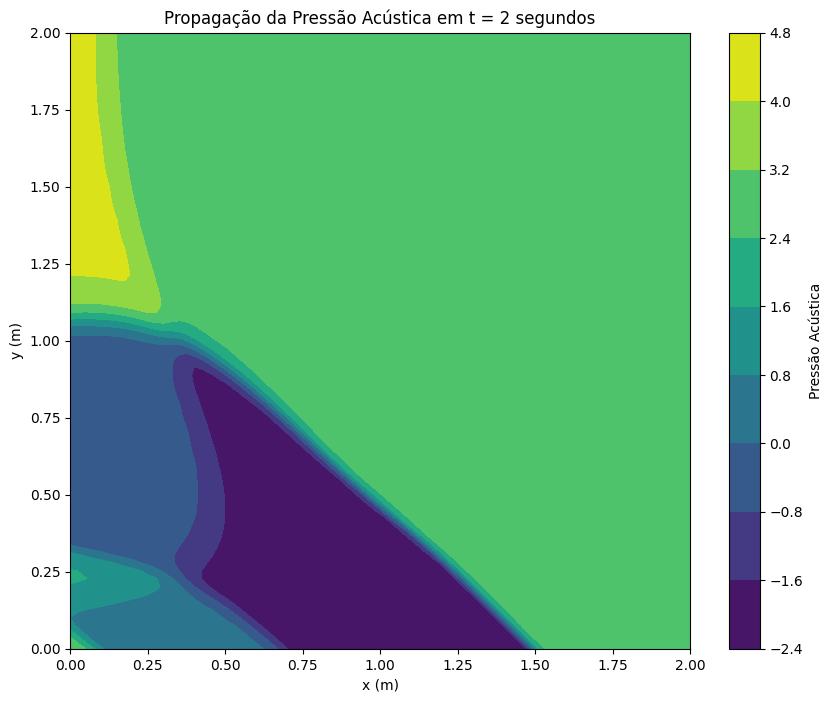

In [ ]:
# Suponha que 'model' é o seu modelo treinado e 'Lx', 'Ly', 'Nx', 'Ny' são os parâmetros da malha
# Defina as coordenadas da malha
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Crie os dados de entrada para o tempo t = 2 segundos
T_fixed = np.full(X.shape, 2.0)  # Cria um array com o tempo t = 2 para cada ponto da malha
inputs = np.stack([X.flatten(), Y.flatten(), T_fixed.flatten()], axis=1)

# Converta os dados de entrada para um tensor e faça previsões com o modelo
inputs_tensor = tf.convert_to_tensor(inputs, dtype=tf.float32)
pressao_predita = model(inputs_tensor)

# Reshape dos resultados para o formato da malha
pressao_predita_reshaped = pressao_predita.numpy().reshape(Nx, Ny)

# Visualize a propagação da pressão
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, pressao_predita_reshaped, cmap='viridis')
plt.colorbar(label='Pressão Acústica')
plt.title('Propagação da Pressão Acústica em t = 2 segundos')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()
